In [1]:
import numpy as np
import datetime
import os
from collections import Counter

import keras
from sklearn.naive_bayes import MultinomialNB
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import sklearn.preprocessing

from utils import generate_data_for_labels, read_pickle

Using TensorFlow backend.


In [2]:
MOST_COMMON = 4

def build_model(input_shape, n_classes):
    model = Sequential()
    model.add(
        Dense(256, input_shape=input_shape)
    )
    model.add(
        Dense(n_classes, activation='softmax')
    )
    return model


def get_callbacks(prefix, base_dir):
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
    log_dir = base_dir + 'logs/{}_{}/'.format(prefix, timestamp)
    print('log_dir {}'.format(log_dir))
    model_checkpoint_dir = base_dir + 'models/{}_{}/'.format(prefix, timestamp)

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(model_checkpoint_dir):
        os.makedirs(model_checkpoint_dir)

    # build a tensorboard callback object using the above log dir
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_images=False
    )
    # # build a model checkpoint callback object using the above model checkpoint dir
    checkpoint_callback = ModelCheckpoint(
        model_checkpoint_dir + 'best_weights.hdf5',
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode='auto'
    )
    early_stopping_callback = EarlyStopping(patience=10)

    return [checkpoint_callback, tensorboard_callback, early_stopping_callback]


In [3]:

def get_pd(x, y):
    xn = (x - x.min(0)) / x.ptp(0)
    clf = MultinomialNB()
    clf.fit(xn, y)
    return clf.predict_proba(xn)


def fine_tune_model(model, videos, audios, original_labels, base_dir, prefix):
    model.layers[-1].trainable = False

    model.compile(
        optimizer=Adam(lr=1e-4),
        loss=losses.kld
    )
    pd = get_pd(audios, original_labels)

    epochs_2 = 500

    model.fit(
        videos,
        pd,
        epochs=epochs_2,
        validation_split=0.15,
        callbacks=get_callbacks('{}_2'.format(prefix), base_dir)
    )


In [4]:
base_dir = '/mnt/disks/sup/finetune/'
prefix = 'concat-256-kl'
epochs_1 = 100
videos_file = base_dir + 'video.pkl'
audios_file = base_dir + 'audio.pkl'
video_labels_file = base_dir + 'labels.pkl'
# video_labels = read_pickle(video_labels_file).flatten()
# unique_labels = np.array(list(set(video_labels)))
# print "Original Unique Labels", len(unique_labels)
# c = Counter(video_labels)
# chosen_labels = []
# for word, count in c.most_common(MOST_COMMON):
#     chosen_labels.append(word)
# chosen_labels = np.array(chosen_labels)

# videos, labels = generate_data_for_labels(videos_file, video_labels, chosen_labels, Transpose=1)
# print('video done')
# audios, a_labels = generate_data_for_labels(audios_file, video_labels, chosen_labels, Transpose=1)


In [5]:
# videos.shape, audios.shape

In [6]:
import cPickle as pickle

In [7]:
# original_labels = labels
# label_binarizer = sklearn.preprocessing.LabelBinarizer()
# label_binarizer.fit(range(len(chosen_labels)))
# labels = label_binarizer.transform(labels)


In [8]:
videos_savepath = base_dir + 'save_videos.pkl'
# with open(videos_savepath, 'wb') as vsp:
#     pickle.dump(videos, vsp)
    
audios_savepath = base_dir + 'save_audios.pkl'
# with open(audios_savepath, 'wb') as asp:
#     pickle.dump(audios, asp)
    
labels_savepath = base_dir + 'save_labels.pkl'
# with open(labels_savepath, 'wb') as lsp:
#     pickle.dump(labels, lsp)
    
original_labels_savepath = base_dir + 'save_original_labels.pkl'
# with open(original_labels_savepath, 'wb') as olsp:
#     pickle.dump(original_labels, olsp)

In [9]:
with open(videos_savepath, 'rb') as vsp:
    videos = pickle.load(vsp)
    
with open(audios_savepath, 'rb') as asp:
    audios = pickle.load(asp)
    
with open(labels_savepath, 'rb') as lsp:
    labels = pickle.load(lsp)
    
with open(original_labels_savepath, 'rb') as olsp:
    original_labels = pickle.load(olsp)

## Concatenating features before fusing

In [10]:
import numpy as np

In [11]:
videos.shape, audios.shape

((15540, 1024), (15540, 128))

In [12]:
concat = np.hstack([videos, audios])
concat.shape

(15540, 1152)

In [13]:
input_shape = (concat.shape[1],)
model = build_model(input_shape, MOST_COMMON)

model.compile(
    loss=losses.categorical_crossentropy,
    optimizer=Adam(lr=1e-3)
)
epochs_1 = 500
hist1 = model.fit(
    concat, labels,
    epochs=epochs_1,
    verbose=1,
    validation_split=0.15,
    callbacks=get_callbacks('{}_1'.format(prefix), './basedir/')
)

In [14]:
model.layers[-1].trainable = False

model.compile(
    optimizer=Adam(lr=1e-4),
    loss=losses.kld
)
pd = get_pd(audios, original_labels)

epochs_2 = 500

hist2 = model.fit(
    concat,
    pd,
    epochs=epochs_2,
    validation_split=0.15,
    callbacks=get_callbacks('{}_2'.format(prefix), './basedir/')
)

In [15]:
get_first_output = keras.backend.function([model.layers[0].input], [model.layers[0].output])
first_output = get_first_output([concat])[0]

In [16]:
first_output.shape

(15540, 256)

In [17]:
videos_projected_path = './basedir/concat_projected_256.pkl'
with open(videos_projected_path, 'wb') as vpp:
    pickle.dump(first_output, vpp)
    
video_labels_path = './basedir/concat_projected_256_labels.pkl'
with open(video_labels_path, 'wb') as vlp:
    pickle.dump(original_labels, vlp)

In [18]:
from sklearn.manifold import TSNE

from tsne import plot_with_labels

def plot_tsne(x, y, title):
    tsne_sklearn = TSNE()
    np.set_printoptions(suppress=True)
    x_2 = tsne_sklearn.fit_transform(x, y)
    plot_with_labels(x_2, y, title)

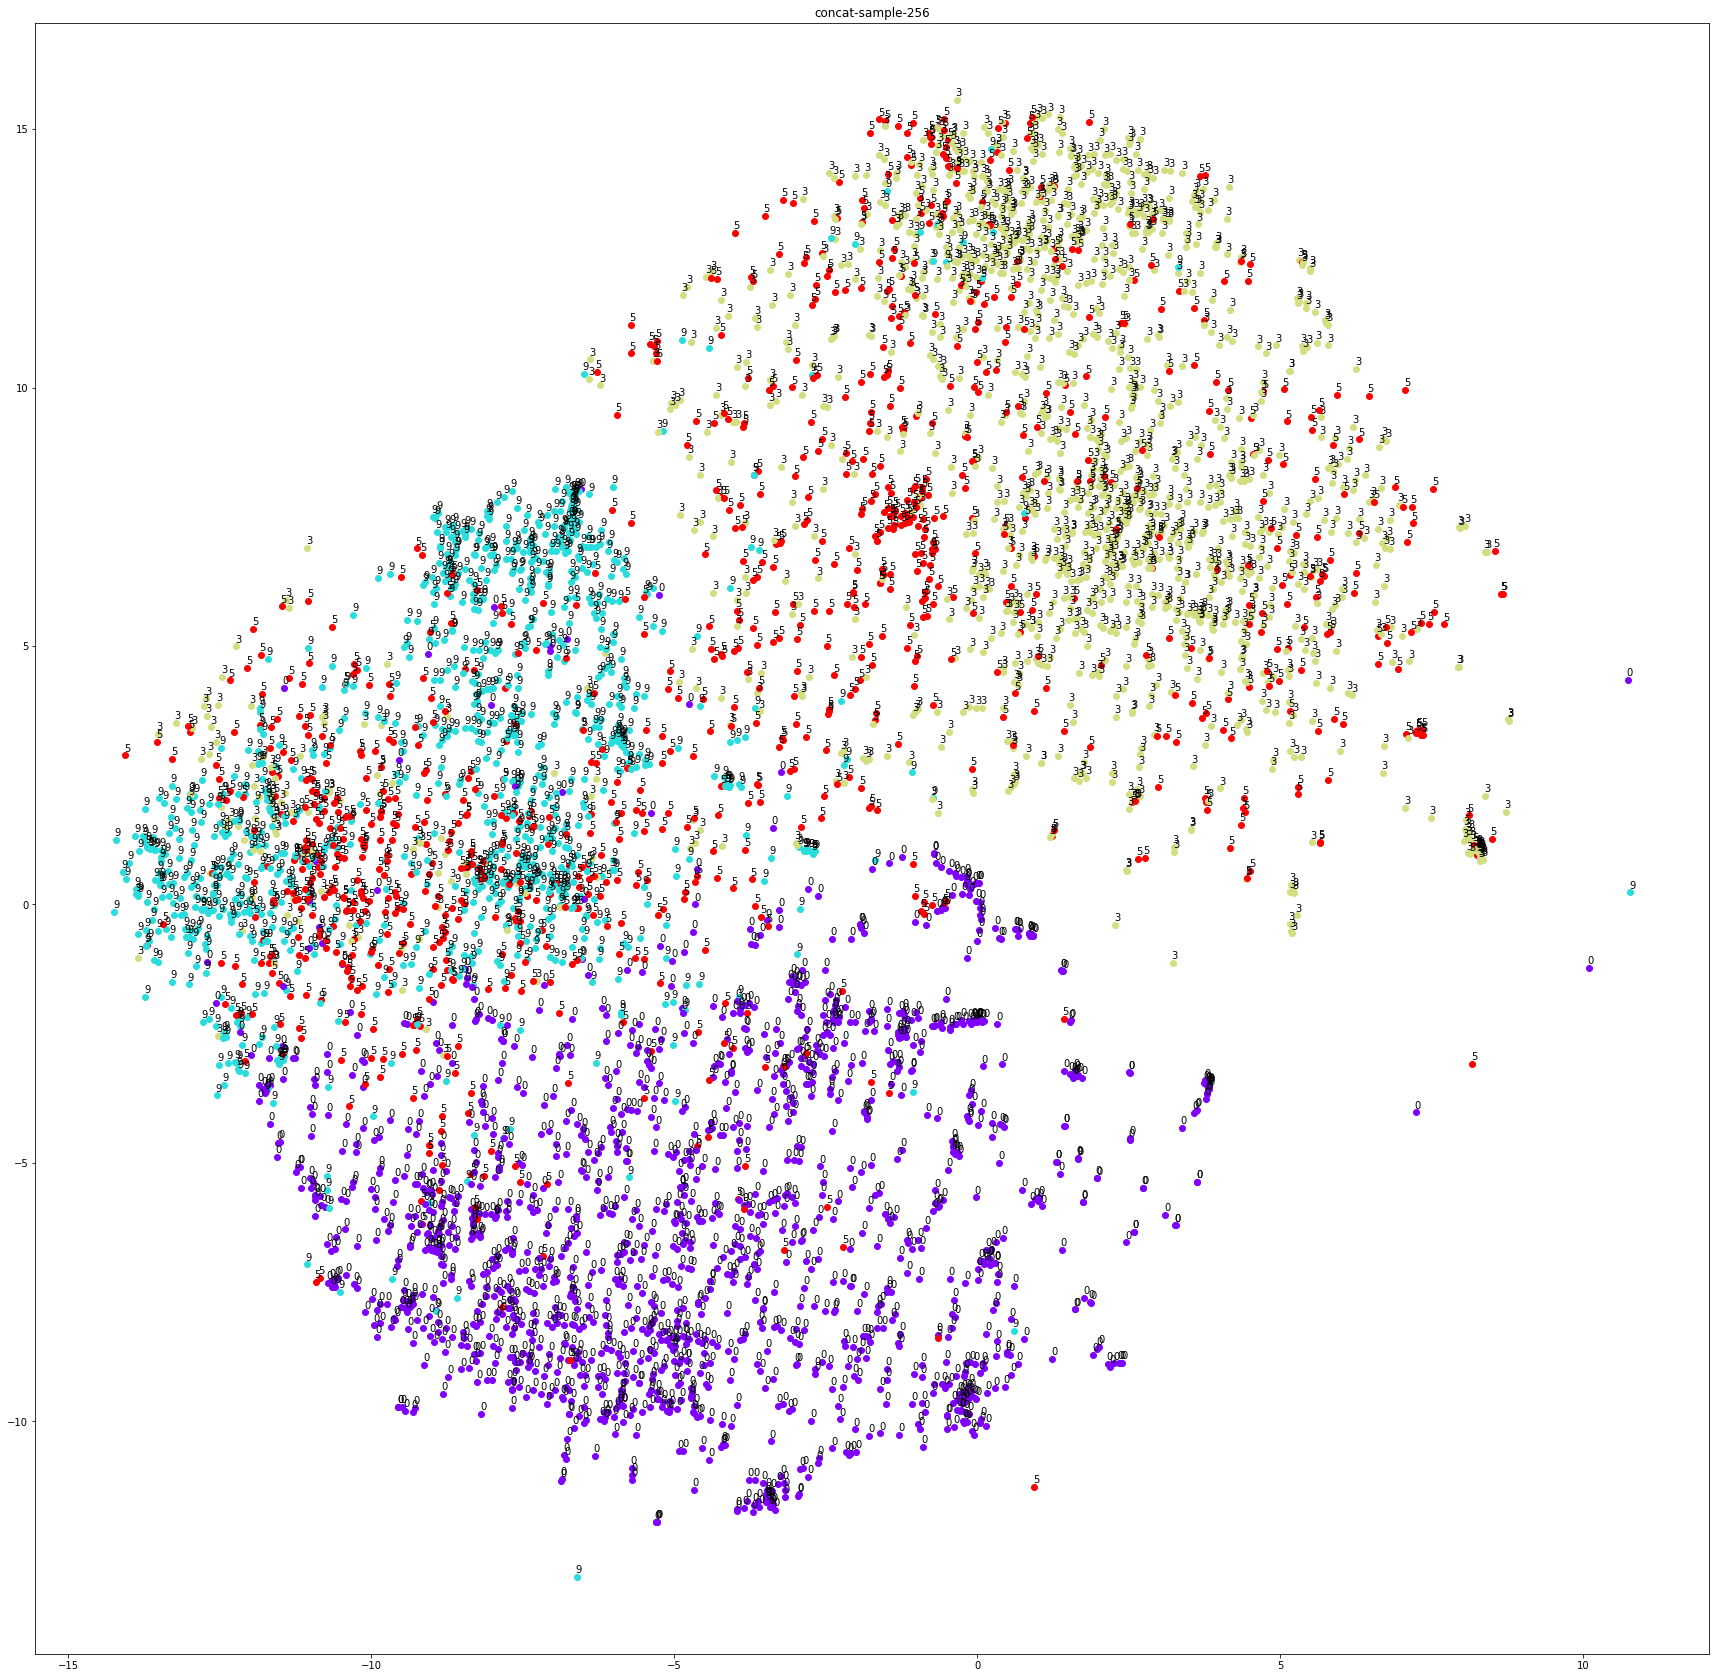

In [19]:
import random
N = len(videos)
selection_size = 5000
sel = random.sample(range(N), selection_size)
videos_sample = first_output[sel]
labels_sample = original_labels[sel]

plot_tsne(videos_sample, labels_sample, 'concat-sample-256')